In [1]:
import numpy as np

In [2]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\Data\formationchannels.npy")

In [3]:
import matplotlib.pyplot as plt

Plot raw data distribution

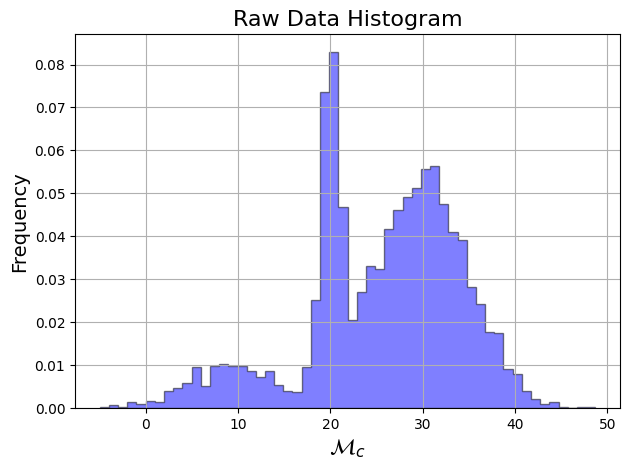

In [4]:
counts, bins, _ = plt.hist(data, bins=int(np.sqrt(data.shape[0])), histtype='stepfilled', edgecolor='black',color='blue', alpha=0.5, density=True)
plt.title('Raw Data Histogram', fontsize=16)
plt.grid()
plt.ylabel('Frequency',fontsize=14)
plt.xlabel(r'$\mathcal{M}_c$', fontsize=16)
plt.tight_layout()

Looks like we're dealing with a 3 modes (gaussian) model.

In [5]:
from sklearn.mixture import GaussianMixture as GM

In [6]:
NMix = 3 # Number of gaussians
init_means  = np.array([10, 20, 30]).reshape((3,1)) # Initial means of the gaussians

In [7]:
GM_instance = GM(NMix, verbose=1, warm_start=False, means_init=init_means)

In [8]:
x = np.linspace(0,50,51)
x = x.reshape((x.shape[0],1))

In [9]:
results = GM_instance.fit(data)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.


In [10]:
scores = results.score_samples(x) # returns log likelihoods as a function of x

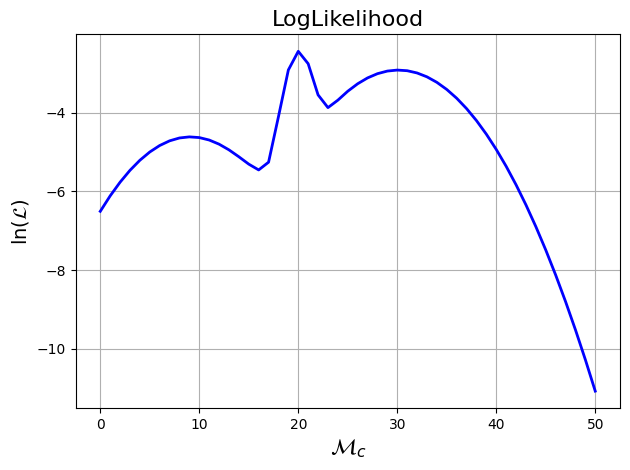

In [11]:
plt.plot(x,scores,linewidth=2, color='blue')
plt.title('LogLikelihood', fontsize=16)
plt.grid()
plt.ylabel(r'$\ln(\mathcal{L})$',fontsize=14)
plt.xlabel(r'$\mathcal{M}_c$', fontsize=16)
plt.tight_layout()

In [12]:
means = results.means_ # modes means

In [13]:
sigmas = results.covariances_ # modes covariance matrices

In [14]:
weights = results.weights_ # modes weights

In [15]:
from scipy.stats import norm

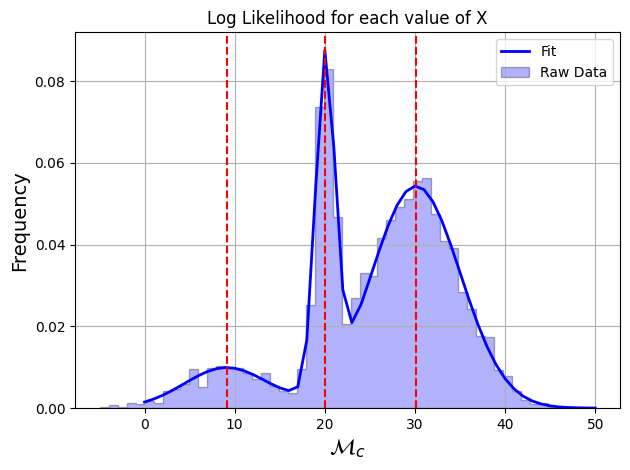

In [16]:
plt.plot(np.exp(scores),linewidth=2,color='blue',label='Fit')
for m,s in zip(means,sigmas):
    x_temp = np.arange(m[0]-3*s[0][0], m[0]+3*s[0][0], 100)
    plt.axvline(m[0], 0, 1, color='r', linestyle='--')
plt.hist(data, bins=int(np.sqrt(data.shape[0])), histtype='stepfilled', edgecolor='black', density=True, color='blue',alpha=0.3, label='Raw Data')
plt.title('Log Likelihood for each value of X')
plt.grid()
plt.ylabel('Frequency',fontsize=14)
plt.xlabel(r'$\mathcal{M}_c$', fontsize=16)
plt.tight_layout()
plt.legend()

Seems right, let's compute the Akaike Information Criterion value

In [17]:
AIC = results.aic(x) # Akaike Information Criterion
print(f'AIC = {AIC:.2}')

AIC = 5.2e+02


We can now compute $p(j|\vec{x}) = \frac{\alpha_j \mathcal{N}(\vec{x},\mu_j,\sigma_j)}{\sum_{i=1}^{N}\alpha_j \mathcal{N}(\vec{x},\mu_j,\sigma_j)}$

In [18]:
from scipy.stats import norm

In [19]:
weighted_G = np.array([weights[i]*norm.pdf(x.reshape((51)), loc=means[i][0], scale=sigmas[i][0]) for i in range(3)])

In [20]:
P = weighted_G/ np.sum(weighted_G)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\ricca\AppData\Local\Temp\ipykernel_12244\3947112318.py:1: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x,np.sum(P, axis=0),linewidth=2,color='blue',label=f'$\sum_j p(j|x)$ = {np.sum(np.sum(P,axis=0)):.2}')


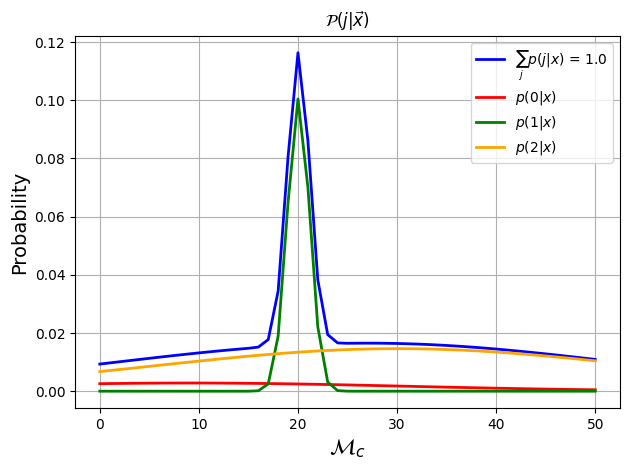

In [21]:
plt.plot(x,np.sum(P, axis=0),linewidth=2,color='blue',label=f'$\sum_j p(j|x)$ = {np.sum(np.sum(P,axis=0)):.2}')
plt.plot(x,P[0],linewidth=2,color='red',label='$p(0|x)$')
plt.plot(x,P[1],linewidth=2,color='green',label='$p(1|x)$')
plt.plot(x,P[2],linewidth=2,color='orange',label='$p(2|x)$')
plt.title(r'$\mathcal{P}(j|\vec{x})$')
plt.grid()
plt.ylabel('Probability',fontsize=14)
plt.xlabel(r'$\mathcal{M}_c$', fontsize=16)
plt.legend()
plt.tight_layout()

We can do all of the previous steps for a generic number of modes.

In [22]:
NMixs = np.arange(1,20,1) # Number of gaussians

In [23]:
results_dic = {
    'NM' : [],
    'Scores': [],
    'AIC': [],
    'BIC': [],
    'Probs' : [],
    'Labels' : [],
    'Means' : [],
    'Covars' : [],
    'Weights' : []
}

Text(0, 0.5, '$\\ln(\\mathcal{L})$')

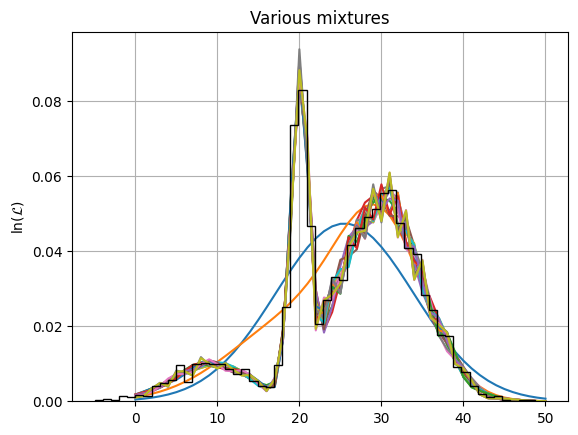

In [24]:
for NM in NMixs:
    mixture_components = NMix
    GM_instance = GM(NM, covariance_type='full', n_init=20)
    results = GM_instance.fit(data)
    if results.converged_ == True:
        scores = results.score_samples(x)
        plt.plot(np.exp(scores), label=f'{NM}')
        results_dic['NM'].append(NM)
        results_dic['Scores'].append(results.score_samples(x))
        results_dic['AIC'].append(results.aic(x))
        results_dic['BIC'].append(results.bic(x))
        results_dic['Probs'].append(results.predict_proba(x))
        results_dic['Labels'].append(results.predict(x))
        results_dic['Means'].append(results.means_)
        results_dic['Covars'].append(results.covariances_)
        results_dic['Weights'].append(results.weights_)

plt.hist(data, bins=int(np.sqrt(data.shape[0])), histtype='step', edgecolor='black', density=True)
plt.title('Various mixtures')
plt.grid()
plt.ylabel(r'$\ln(\mathcal{L})$')
#plt.legend()

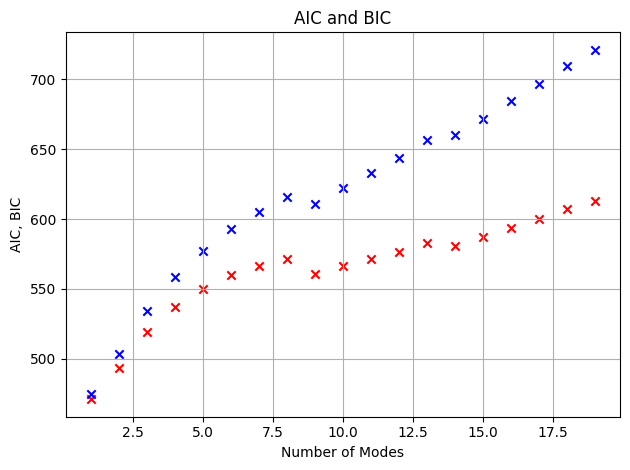

In [27]:
plt.scatter(results_dic['NM'], results_dic['AIC'], marker='x', color='red', label='AIC')
plt.scatter(results_dic['NM'], results_dic['BIC'], marker='x', color='blue', label='BIC')
plt.grid()
plt.title('AIC and BIC')
plt.ylabel('AIC, BIC')
plt.xlabel('Number of Modes')
plt.tight_layout()

This is NOT expected!\
I would expect to see the AIC decreasing  untill $N=3$. After that I would expect it to increase.

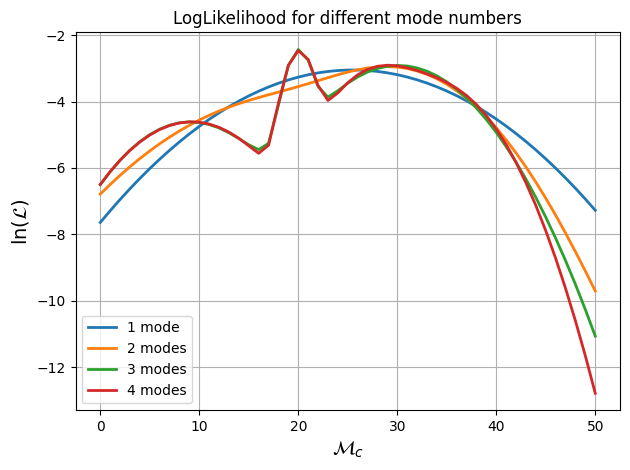

In [28]:
plt.plot(results_dic['Scores'][0], label='1 mode',linewidth=2)
plt.plot(results_dic['Scores'][1], label='2 modes',linewidth=2)
plt.plot(results_dic['Scores'][2], label='3 modes',linewidth=2)
plt.plot(results_dic['Scores'][3], label='4 modes',linewidth=2)
plt.grid()
plt.title('LogLikelihood for different mode numbers')
plt.ylabel(r'$\ln(\mathcal{L})$',fontsize=14)
plt.xlabel(r'$\mathcal{M}_c$',fontsize=14)
plt.legend()
plt.tight_layout()

Ok this explains something.\
We can see that adding one mode does not change the $\ln(\mathcal{L})$ thus we could say we can stick with 3 modes.\
There is a weird peak arounfd $20 \mathcal{M}_c$ that is exactly the position of the second peak in the data. Not that weird.\
I would like to explore the problem of the AIC penalizing the 3 modes model further.

## ***Wilks’ theorem*** 
states that if we compare nested models (one model is a special case of the other), then the likelihood ratio statistic $\lambda = -2 (ln(\mathcal{L}_1) - ln(\mathcal{L}_2))$
follows a chi-squared distribution with degrees of freedom equal to the difference in the number of free parameters.

In [29]:
# Extract log-likelihoods
logL1 = results_dic['Scores'][1].sum()  # log-likelihood for 2 modes
logL2 = results_dic['Scores'][2].sum()  # log-likelihood for 3 modes

In [30]:
from scipy.stats import chi2

# Compute likelihood ratio statistic
lambda_stat = -2 * (logL1 - logL2)

# Compute degrees of freedom (3 extra parameters per mode)
k_diff = 3 * (3 - 2)  # (means, variances, and weights)

# Compute p-value
p_value = 1 - chi2.cdf(lambda_stat, df=k_diff)

print(f"Log-likelihood (2 modes): {logL1:.2f}")
print(f"Log-likelihood (3 modes): {logL2:.2f}")
print(f"Likelihood Ratio Statistic: {lambda_stat:.2f}")
print(f"Degrees of Freedom: {k_diff}")
print(f"P-value: {p_value:.4f}")

Log-likelihood (2 modes): -241.79
Log-likelihood (3 modes): -251.49
Likelihood Ratio Statistic: -19.38
Degrees of Freedom: 3
P-value: 1.0000


WEIRD! since p-value $=1$ this means that adding a mode to thw two modes model doesn't change anything at all.

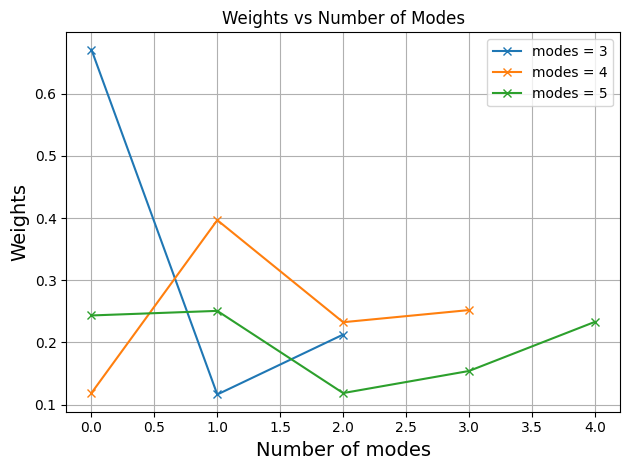

In [31]:
plt.plot(results_dic['Weights'][2], marker='x', label=f'modes = {results_dic['NM'][2]}')
plt.plot(results_dic['Weights'][3], marker='x', label=f'modes = {results_dic['NM'][3]}')
plt.plot(results_dic['Weights'][4], marker='x', label=f'modes = {results_dic['NM'][4]}')
plt.grid()
plt.title('Weights vs Number of Modes')
plt.ylabel('Weights',fontsize=14)
plt.xlabel('Number of modes',fontsize=14)
plt.tight_layout()
plt.legend()

In [32]:
def extract_entries_by_index(arrays):
    """
    Extracts elements from each index position across all arrays.

    Parameters:
        arrays (list of np.array): List of NumPy arrays of increasing length.

    Returns:
        list of lists: Each sublist contains elements from the same index position.
    """
    max_length = max(len(arr) for arr in arrays)
    grouped_entries = [[] for _ in range(max_length)]
    
    for arr in arrays:
        for i, value in enumerate(arr):
            grouped_entries[i].append(value)
    
    return grouped_entries


In [33]:
grouped_entries = extract_entries_by_index(results_dic['Weights'])

In [34]:
mns = np.array([np.mean(grouped_entries[i]) for i in range(len(grouped_entries))])

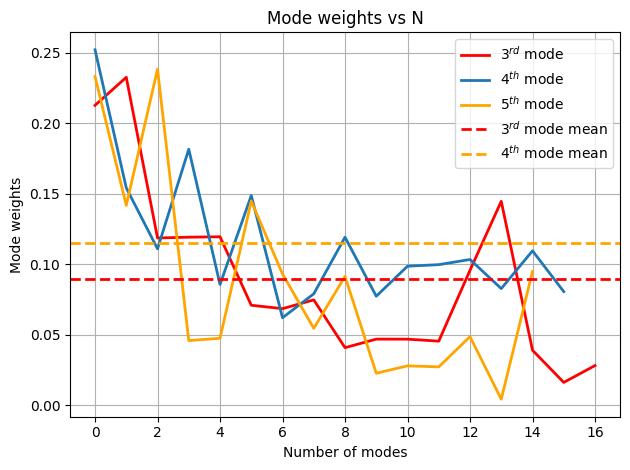

In [35]:
plt.plot(grouped_entries[2], color='red', label=r'$3^{rd}$ mode',linewidth=2)
plt.plot(grouped_entries[3], label=r'$4^{th}$ mode',linewidth=2)
plt.plot(grouped_entries[4], color='orange', label=r'$5^{th}$ mode',linewidth=2)
plt.axhline(mns[2],0,1,linestyle='--',color='red',linewidth=2, label='$3^{rd}$ mode mean')
plt.axhline(mns[3],0,1,linestyle='--',color='orange',linewidth=2, label='$4^{th}$ mode mean')
plt.grid()
plt.title('Mode weights vs N')
plt.xlabel('Number of modes')
plt.ylabel('Mode weights')
plt.legend()
plt.tight_layout()